In [2]:
import os
from glob import glob
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

# =========================
# Base Layer
# =========================
class BaseLayer:
    def forward(self, x):
        raise NotImplementedError

    def backward(self, grad, lr):
        raise NotImplementedError


# =========================
# Activation functions
# =========================
class Activation:
    @staticmethod
    def sigmoid(x):
        return 1 / (1 + torch.exp(-x))

    @staticmethod
    def tanh(x):
        return torch.tanh(x)


class ActivationPrime:
    @staticmethod
    def sigmoid_derivative(x):
        s = Activation.sigmoid(x)
        return s * (1 - s)

    @staticmethod
    def tanh_derivative(x):
        return 1 - torch.tanh(x) ** 2


# =========================
# Loss
# =========================
class Loss:
    @staticmethod
    def mse(y, y_hat):
        return torch.mean((y - y_hat) ** 2)


class LossPrime:
    @staticmethod
    def mse_prime(y, y_hat):
        return 2 * (y_hat - y) / y.numel()


# =========================
# Fully Connected Layer
# =========================
class FCLayer(BaseLayer):
    def __init__(self, in_dim, out_dim):
        self.W = torch.randn(in_dim, out_dim) * 0.1
        self.b = torch.zeros(1, out_dim)
        self.x = None

    def forward(self, x):
        x = x.view(x.size(0), -1)
        self.x = x
        return x @ self.W + self.b

    def backward(self, grad, lr):
        dx = grad @ self.W.T
        dW = self.x.T @ grad
        db = grad.mean(dim=0, keepdim=True)

        self.W -= lr * dW
        self.b -= lr * db

        return dx


# =========================
# Activation Layer
# =========================
class ActivationLayer(BaseLayer):
    def __init__(self, act, act_prime):
        self.act = act
        self.act_prime = act_prime
        self.x = None

    def forward(self, x):
        self.x = x
        return self.act(x)

    def backward(self, grad, lr):
        return self.act_prime(self.x) * grad


# =========================
# Network
# =========================
class Network:
    def __init__(self):
        self.layers = []
        self.loss = None
        self.loss_prime = None

    def add(self, layer):
        self.layers.append(layer)

    def use(self, loss, loss_prime):
        self.loss = loss
        self.loss_prime = loss_prime

    def predict(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def predicts(self, data):
        samples = len(data)
        result = []
        
        # for every input vector data x_i do:
        for i in range(samples):
            # forward propagation
            output = data[i:i+1]  # Keep batch dimension (1, dim)
            for layer in self.layers:
                output = layer.forward(output)
            result.append(output.squeeze(0))  # Remove batch dimension for individual result
        return result

    def fit(self, X, Y, epochs, lr):
        for e in range(epochs):
            total = 0
            for i in range(len(X)):
                out = self.predict(X[i:i+1])
                loss = self.loss(Y[i:i+1], out)
                total += loss

                grad = self.loss_prime(Y[i:i+1], out)
                for layer in reversed(self.layers):
                    grad = layer.backward(grad, lr)

            print(f"Epoch {e+1} | Loss = {total / len(X)}")

    # =========================
    # Save / Load
    # =========================
    def save(self, path):
        model = []
        for layer in self.layers:
            if isinstance(layer, FCLayer):
                model.append({
                    "type": "fc",
                    "in": layer.W.shape[0],
                    "out": layer.W.shape[1],
                    "W": layer.W,
                    "b": layer.b
                })
            else:
                model.append({
                    "type": "act",
                    "name": layer.act.__name__
                })

        torch.save(model, path)
        print("✅ Saved model to", path)

    def load(self, path):
        data = torch.load(path)
        self.layers = []

        for item in data:
            if item["type"] == "fc":
                fc = FCLayer(item["in"], item["out"])
                fc.W = item["W"]
                fc.b = item["b"]
                self.layers.append(fc)
            else:
                if item["name"] == "tanh":
                    self.layers.append(
                        ActivationLayer(Activation.tanh, ActivationPrime.tanh_derivative)
                    )
                elif item["name"] == "sigmoid":
                    self.layers.append(
                        ActivationLayer(Activation.sigmoid, ActivationPrime.sigmoid_derivative)
                    )

        print("✅ Loaded model from", path)


# =========================
# Dataset
# =========================
DATA_ROOT = 'dataset/BIPED/edges'
IMG_TRAIN_DIR = os.path.join(DATA_ROOT, 'imgs/train/rgbr/real')
EDGE_TRAIN_DIR = os.path.join(DATA_ROOT, 'edge_maps/train/rgbr/real')
IMG_TEST_DIR = os.path.join(DATA_ROOT, 'imgs/test/rgbr')
EDGE_TEST_DIR = os.path.join(DATA_ROOT, 'edge_maps/test/rgbr')

PATCH_SIZE = 15
INPUT_DIM = 3 * PATCH_SIZE * PATCH_SIZE
OUTPUT_DIM = 1


class BIPEDPatchDataset(Dataset):
    def __init__(self, img_dir, edge_dir, psize=15, n=200, transform=None):
        self.imgs = sorted(glob(os.path.join(img_dir, "*.jpg")))
        self.edges = [os.path.join(edge_dir, os.path.basename(i).replace('.jpg','.png')) for i in self.imgs]

        self.r = psize // 2
        self.n = n
        self.transform = transform

        self.samples = []
        for i, path in enumerate(self.imgs):
            w, h = Image.open(path).size
            ys = torch.randint(self.r, h - self.r, (n,))
            xs = torch.randint(self.r, w - self.r, (n,))
            for y, x in zip(ys, xs):
                self.samples.append((i, y, x))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        i, y, x = self.samples[idx]
        img = Image.open(self.imgs[i]).convert("RGB")
        edge = Image.open(self.edges[i]).convert("L") if os.path.exists(self.edges[i]) else Image.new('L', img.size)

        img = self.transform(img)
        edge = transforms.ToTensor()(edge)[0]

        patch = img[:, y - self.r:y + self.r + 1, x - self.r:x + self.r + 1].reshape(-1)
        label = (edge[y, x] > 0.5).float().view(1)

        return patch, label



In [ ]:

# =========================
# Train
# =========================
transform = transforms.ToTensor()
dataset = BIPEDPatchDataset(IMG_TRAIN_DIR, EDGE_TRAIN_DIR, transform=transform)
loader = DataLoader(dataset, batch_size=1, shuffle=True)

x_train, y_train = [], []
for patch, label in loader:
    x_train.append(patch)
    y_train.append(label)

x_train = torch.cat(x_train)
y_train = torch.cat(y_train)

net = Network()
net.add(FCLayer(INPUT_DIM, 128))
net.add(ActivationLayer(Activation.tanh, ActivationPrime.tanh_derivative))
net.add(FCLayer(128, 64))
net.add(ActivationLayer(Activation.tanh, ActivationPrime.tanh_derivative))
net.add(FCLayer(64, OUTPUT_DIM))

net.use(Loss.mse, LossPrime.mse_prime)
net.fit(x_train, y_train, epochs=3, lr=1e-4)
net.save("simple_edge_model.pth")


In [6]:
net2 = Network()
net2.load("simple_edge_model.pth")

pred = net2.predict(x_train[0:1])
print("Pred:", pred.item(), "Label:", y_train[0].item())


✅ Loaded model from simple_edge_model.pth
Pred: 0.026531852781772614 Label: 0.0


In [19]:
out = net2.predict(x_train[:100])
print([o.item() for o in out[:10]])



[0.026531746610999107, 0.02728326804935932, 0.04388376325368881, 0.005669916048645973, 0.007625708356499672, 0.032685019075870514, 0.029923090711236, 0.0629652738571167, 0.005096917971968651, -0.012126879766583443]


NameError: name 'x' is not defined

✅ Loaded model from simple_edge_model.pth


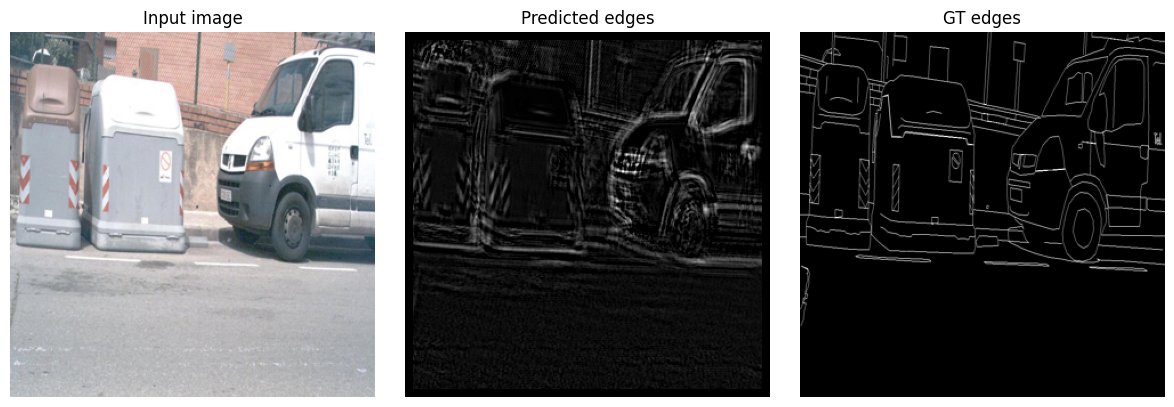

In [26]:
import matplotlib.pyplot as plt

@torch.no_grad()
def predict_edge_map(net, img_path, patch_size=PATCH_SIZE):
    radius = patch_size // 2

    img = Image.open(img_path).convert('RGB')
    img_resized = img.resize((320, 320))  # giống transform train
    img_t = transforms.ToTensor()(img_resized)  # 3xH xW

    _, H, W = img_t.shape
    edge_pred = torch.zeros((H, W), dtype=torch.float32)

    for y in range(radius, H - radius):
        patch_rows = []
        xs = list(range(radius, W - radius))
        for x in xs:
            y1, y2 = y - radius, y + radius + 1
            x1, x2 = x - radius, x + radius + 1
            patch = img_t[:, y1:y2, x1:x2].contiguous().view(1, -1)
            patch_rows.append(patch)

        row_batch = torch.cat(patch_rows, dim=0)  # (num_x, dim)
        preds = net.predicts(row_batch)
        preds = torch.stack(preds).squeeze()    # (num_x,)
        edge_pred[y, radius:W-radius] = preds 
        
    edge_pred = torch.clamp(edge_pred, 0.0, 1.0)
    return img_resized, edge_pred


def visualize_edge_on_test_index(net, idx=0):
    test_imgs = sorted(glob(os.path.join(IMG_TEST_DIR, '*.jpg')))
    if len(test_imgs) == 0:
        print('No test images found in', IMG_TEST_DIR)
        return

    img_path = test_imgs[idx % len(test_imgs)]

    # cố gắng load GT nếu có
    base = os.path.splitext(os.path.basename(img_path))[0]
    gt_path = os.path.join(EDGE_TEST_DIR, base + '.png')
    gt = None
    if os.path.exists(gt_path):
        gt_img = Image.open(gt_path).convert('L').resize((320, 320))
        gt = transforms.ToTensor()(gt_img)[0]

    img_resized, edge_pred = predict_edge_map(net, img_path)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(img_resized)
    plt.title('Input image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(edge_pred.cpu().numpy(), cmap='gray')
    plt.title('Predicted edges')
    plt.axis('off')

    if gt is not None:
        plt.subplot(1, 3, 3)
        plt.imshow(gt.cpu().numpy(), cmap='gray')
        plt.title('GT edges')
        plt.axis('off')
    else:
        plt.subplot(1, 3, 3)
        plt.imshow(edge_pred.cpu().numpy() > 0.5, cmap='gray')
        plt.title('Pred > 0.5 (no GT)')
        plt.axis('off')

    plt.tight_layout()
    plt.show()


# Reload model to get updated Network class with predicts method
net = Network()
net.load("simple_edge_model.pth")

# ví dụ chạy thử trên 1 ảnh test
visualize_edge_on_test_index(net, idx=0)